# The reconstruction loss can be reduced to 0.0066 with 1-split while only to 0.0084 with 4-split.

In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.decode(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * n_filters[0]),  # factor 4 due to conv.
            Reshape((io_shape[0]//4, io_shape[1]//4, n_filters[0])),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])

Pretrain 1-split until loss saturates and save encoder weights.

In [2]:
import keras
import numpy as np

n_splits = 1
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')

Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0220 - val_loss: 0.0110
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 8/50
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 9/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 10/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.007

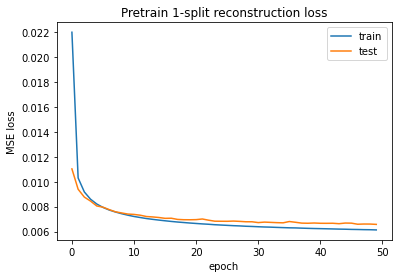

<Figure size 432x288 with 0 Axes>

In [3]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=50, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pretrain 1-split reconstruction loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('../img/22/CE16_epoch50.png')

In [4]:
model.encoder.save_weights('../weights/22_CE16_epoch50.h5')

Pretrain 4-split until loss saturates and save encoder weights.

In [5]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')

Epoch 1/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0232 - val_loss: 0.0142
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0134 - val_loss: 0.0124
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0121 - val_loss: 0.0116
Epoch 4/50
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 8/50
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 9/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 10/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.009

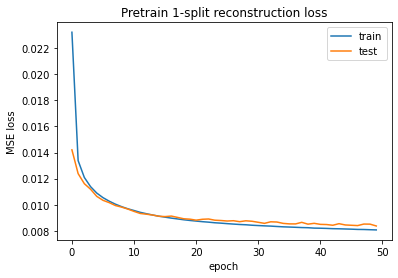

<Figure size 432x288 with 0 Axes>

In [6]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=50, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pretrain 1-split reconstruction loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('../img/22/CE4x4_epoch50.png')

In [7]:
model.encoder.save_weights('../weights/22_CE4x4_epoch50.h5')